In [1]:
# Attitude/Pointing Error vs Efficiency MONTY
# Created: 10/12/2022
# Author: Cameron King
# Function Authors: Henri Wessels, Alec Church

# Description:
#
# This is the script that runs a monte-carlo simulation on the model set up in the main script
# It will vary amounts of attitude error to determine resulting efficiency (specifically efficiency associated with attitude error)


# libraries
import math
import numpy
import mpmath
import matplotlib.pyplot as plt
import time

# functions
from ipynb.fs.full.efficiency_funcs import *

def power_transmission_func(r_ideal,d_ideal,d_actual,P):
    # This function will model a conular beam with defining d_ideal and r_ideal
    # It will output the flux distribution in 
    # Assumptions: the beam comes from a point source on the SC
    
    alpha = mpmath.atan(r_ideal/d_ideal) # view angle, half of FOV basically
    
    r_actual = d_actual*mpmath.tan(alpha) # actual radius of receiver at actual distance d
    r_actual = float(r_actual)
    
    # Set up assumed gaussian distribution
    
    r = [0,r_actual*0.5,r_actual*0.75,r_actual*0.9,r_actual*0.99,r_actual*1]
    
    p = [P*1,P*0.6,P*0.2,P*0.1,P*0.04,P*0.01]
    
    return [r,p]
    

<function matplotlib.pyplot.show(close=None, block=None)>

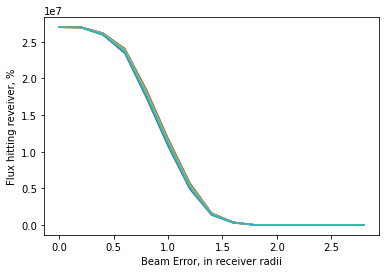

In [2]:
# vary errors by radius of receiver ( increase receiver size, beam position tolerance increases by the same amount )
#
# only does this for one given altitude and transmission time

P_avail = 30000000 # power available to transmit

t_step = 1;
t_end = 10;
r = 5;
h = 30000;
N = t_end/t_step
N = int(N);

# Constants
mu_m = 4.905E12; # Gravitational parameter of the moon, 
r_m = 1737500; # radius of the moon, m


# Functions #
def FOV_func(x,r,h): # determines the angular field of view of receiver, as func of x, r, and h
    FOV = 2*(numpy.arctan((x+r)/h)-numpy.arctan(x/h))
    return FOV

 # Calculations
V = math.sqrt(mu_m/(r_m+h)); # orbital velocity
x_max = V*t_end/2; # Maximum transmission ground distance, x(t=0) at start of transmission
FOV_min = FOV_func(x_max,r,h); # smallest field of view, at maximum distance

# ideal beam radius: the average radius of receiver over transmission period
r_min = math.sqrt(x_max**2+h**2)*numpy.tan(FOV_min/2); # minimum radius based on FOV
r_b = (r + r_min)/2; # average visual radius, ideal beam radius at surface

# average transmission distance
d_max = numpy.sqrt(x_max**2+h**2);
d_ave = (d_max + h)/2;

abs_pos_err = numpy.arange(0,3,0.20) # ground position error ranges from 0 to 3 TIMES the radius of receiver

# preallocation
t = numpy.zeros(N);
x = numpy.zeros(N);
theta = numpy.zeros(N);
d = numpy.zeros(N);
n_pos = numpy.zeros((N,len(abs_pos_err)))


# loopin
    
for j in range(0,len(abs_pos_err)):

    pos_err = [abs_pos_err[j]*r,0,0];
    point_err = [0,0];
    
    
    for i in range(0,N):
        t[i] = i*t_step;
        x[i] = V*t[i] - x_max;
        theta[i] = mpmath.atan(x[i]/h);
        d[i] = math.sqrt(x[i]**2 + h**2)
        
        F_disp = power_transmission_func(r_b,d_ave,d[i],P_avail)
        
        n_pos[i,j] = position_eff_func(theta[i], pos_err, point_err, F_disp, h, r);
        
# plottin

plt.figure()
for i in range(0,len(n_pos[:,0])):
    plt.plot(abs_pos_err, n_pos[i,:])
plt.xlabel('Beam Error, in receiver radii')
plt.ylabel('Flux hitting reveiver, %')
plt.show
